In [41]:
import gensim
import pandas as pd
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.matutils import Sparse2Corpus
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
# CSV 파일 읽기
df_2023 = pd.read_csv('Data/wearable_devices_processed_2023.csv', usecols=['cleaned_abstract'])

In [43]:
def lda_modeling(cleaned_abstracts):
    # TF-IDF를 사용하여 텍스트 데이터 벡터화
    vectorizer = TfidfVectorizer(max_df=0.75, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(cleaned_abstracts)

    # 데이터 벡터화된 것을 gensim에서 사용할 수 있도록 변환
    corpus = Sparse2Corpus(X, documents_columns=False)
    id2word = {i: token for i, token in enumerate(vectorizer.get_feature_names_out())}

    # Perplexity와 Coherence 저장할 리스트 초기화
    perplexity_scores = []
    coherence_scores = []
    topic_range = range(5, 31, 1)  # 5에서 30까지 1단위로 토픽 수 조정

    # 각 토픽 수에 따른 LDA 모델 학습 및 평가
    for num_topics in topic_range:
        # sklearn LDA 모델 학습
        lda_model = LatentDirichletAllocation(n_components=num_topics, learning_decay=0.7, random_state=42)
        lda_model.fit(X)

        # Perplexity 계산 (scikit-learn의 LDA 모델로 계산)
        perplexity = lda_model.perplexity(X)
        perplexity_scores.append(perplexity)

        # Gensim의 LDA 모델을 사용해 Coherence 계산
        gensim_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            passes=10,
            iterations=50,
            random_state=42,
            alpha='auto'
        )

        # Coherence 계산
        coherence_model = CoherenceModel(
            model=gensim_model,
            texts=[doc.split() for doc in cleaned_abstracts],  # 'cleaned_abstracts'를 텍스트로 변환
            dictionary=Dictionary.from_corpus(corpus, id2word),
            coherence='c_v'
        )
        coherence = coherence_model.get_coherence()
        coherence_scores.append(coherence)

    # 결과 반환
    return perplexity_scores, coherence_scores, X, vectorizer

In [44]:
def lda_plot(perplexity_scores, coherence_scores):
    # 토픽 범위 (5에서 30까지 1단위로 토픽 수 조정)
    topic_range = range(5, 31, 1)
    
    # 그래프 크기 설정
    plt.figure(figsize=(12, 5))
    
    # Perplexity 그래프
    plt.subplot(1, 2, 1)
    plt.plot(list(topic_range), perplexity_scores, marker='o', color='blue')
    plt.title('Perplexity of LDA Models')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    for i, txt in enumerate(perplexity_scores):
        plt.annotate("", (topic_range[i], perplexity_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
        # Uncomment to show Perplexity scores as text on graph
        # plt.annotate(f"{txt:.1f}", (topic_range[i], perplexity_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Coherence 그래프
    plt.subplot(1, 2, 2)
    plt.plot(list(topic_range), coherence_scores, marker='o', color='red')
    plt.title('Coherence Score by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    for i, txt in enumerate(coherence_scores):
        plt.annotate("", (topic_range[i], coherence_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
        # Uncomment to show Coherence scores as text on graph
        # plt.annotate(f"{txt:.2f}", (topic_range[i], coherence_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # 그래프 레이아웃 조정 및 출력
    plt.tight_layout()
    plt.show()

## **2023**

In [45]:
perplexity_scores_2023, coherence_scores_2023, X_2023, vectorizer_2023 = lda_modeling(df_2023['cleaned_abstract'])

# 결과 확인
print("Perplexity Scores:", perplexity_scores_2023)
print("Coherence Scores:", coherence_scores_2023)

Perplexity Scores: [3622.067880757059, 3934.7161408858447, 4462.321093385341, 4829.036111514312, 5470.403604037019, 5994.42780486026, 6391.416122314946, 6558.092774731617, 7333.11425050945, 7711.206143387015, 8337.45080710222, 9121.28670671609, 9485.65689345585, 10521.34532237486, 10544.050884988515, 10475.29251165092, 12613.238674777129, 12641.339853232663, 13528.59599940939, 13106.036626515235, 15648.736098002353, 16104.75678916048, 19088.397340706768, 17760.324666207453, 19466.82292625206, 21251.100502512312]
Coherence Scores: [0.5801580088030414, 0.5533823597291807, 0.5782133228812211, 0.5853367062492296, 0.5856721906730944, 0.560869245001643, 0.5995622890547614, 0.6236606968634022, 0.6079056438479772, 0.5819594059839961, 0.5897594931136398, 0.6039945627282199, 0.592558735207252, 0.5665859742726357, 0.6038386280232096, 0.5994660114550254, 0.617816316764361, 0.5915569018379048, 0.5937138190178429, 0.6269877082230316, 0.571982797862824, 0.5685478233896029, 0.5653884630018448, 0.60950

In [46]:
for i, (p, c) in enumerate(zip(perplexity_scores_2023, coherence_scores_2023), start=5):
    print(f"topic {i} - {round(p, 2)}(perplexity), {round(c, 2)}(coherence)")

topic 5 - 3622.07(perplexity), 0.58(coherence)
topic 6 - 3934.72(perplexity), 0.55(coherence)
topic 7 - 4462.32(perplexity), 0.58(coherence)
topic 8 - 4829.04(perplexity), 0.59(coherence)
topic 9 - 5470.4(perplexity), 0.59(coherence)
topic 10 - 5994.43(perplexity), 0.56(coherence)
topic 11 - 6391.42(perplexity), 0.6(coherence)
topic 12 - 6558.09(perplexity), 0.62(coherence)
topic 13 - 7333.11(perplexity), 0.61(coherence)
topic 14 - 7711.21(perplexity), 0.58(coherence)
topic 15 - 8337.45(perplexity), 0.59(coherence)
topic 16 - 9121.29(perplexity), 0.6(coherence)
topic 17 - 9485.66(perplexity), 0.59(coherence)
topic 18 - 10521.35(perplexity), 0.57(coherence)
topic 19 - 10544.05(perplexity), 0.6(coherence)
topic 20 - 10475.29(perplexity), 0.6(coherence)
topic 21 - 12613.24(perplexity), 0.62(coherence)
topic 22 - 12641.34(perplexity), 0.59(coherence)
topic 23 - 13528.6(perplexity), 0.59(coherence)
topic 24 - 13106.04(perplexity), 0.63(coherence)
topic 25 - 15648.74(perplexity), 0.57(cohere

In [47]:
# perplexity, coherence 합(오름차순)
topic_summary = []

for i, (p, c) in enumerate(zip(perplexity_scores_2023, coherence_scores_2023), start=5):
    total_score = p + c  
    topic_summary.append((i, round(p, 2), round(c, 2), round(total_score, 2)))


topic_summary_sorted = sorted(topic_summary, key=lambda x: x[3])

# 결과 확인
print("Topic | Perplexity | Coherence | Sum")
print("-------------------------------------")
for topic, p, c, total in topic_summary_sorted:
    print(f"{topic:>5} | {p:>10} | {c:>9} | {total:>6}")

Topic | Perplexity | Coherence | Sum
-------------------------------------
    5 |    3622.07 |      0.58 | 3622.65
    6 |    3934.72 |      0.55 | 3935.27
    7 |    4462.32 |      0.58 | 4462.9
    8 |    4829.04 |      0.59 | 4829.62
    9 |     5470.4 |      0.59 | 5470.99
   10 |    5994.43 |      0.56 | 5994.99
   11 |    6391.42 |       0.6 | 6392.02
   12 |    6558.09 |      0.62 | 6558.72
   13 |    7333.11 |      0.61 | 7333.72
   14 |    7711.21 |      0.58 | 7711.79
   15 |    8337.45 |      0.59 | 8338.04
   16 |    9121.29 |       0.6 | 9121.89
   17 |    9485.66 |      0.59 | 9486.25
   20 |   10475.29 |       0.6 | 10475.89
   18 |   10521.35 |      0.57 | 10521.91
   19 |   10544.05 |       0.6 | 10544.65
   21 |   12613.24 |      0.62 | 12613.86
   22 |   12641.34 |      0.59 | 12641.93
   24 |   13106.04 |      0.63 | 13106.66
   23 |    13528.6 |      0.59 | 13529.19
   25 |   15648.74 |      0.57 | 15649.31
   26 |   16104.76 |      0.57 | 16105.33
   28 |   17760

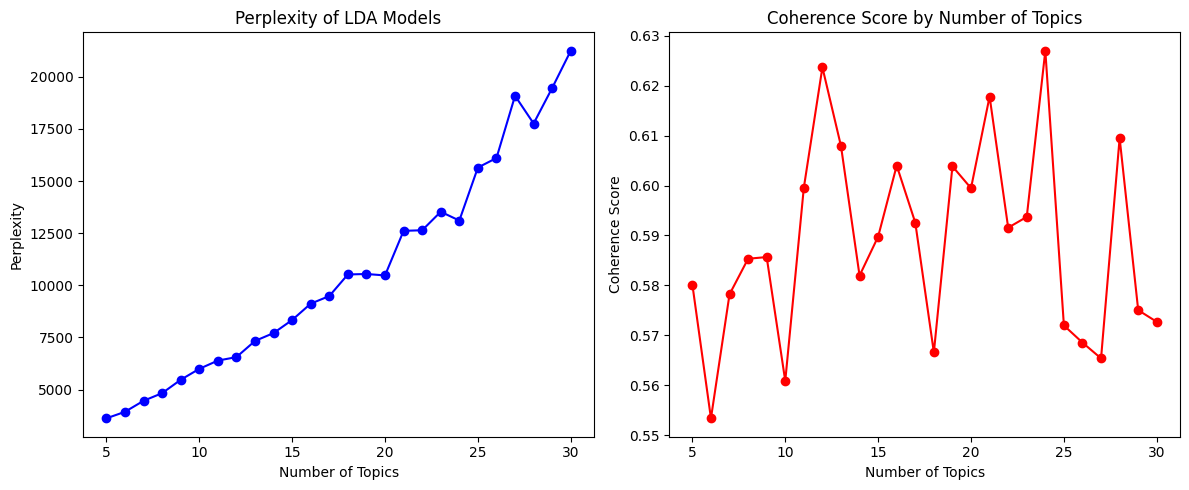

In [48]:
lda_plot(perplexity_scores_2023, coherence_scores_2023)

In [30]:
# 각 토픽에 대한 상위 단어 출력
num_top_words = 20

def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = ', '.join(top_words)
    return topics

### 1) Topic = 8

In [31]:
# 토픽 수
topics_8 = 8

lda = LatentDirichletAllocation(n_components=topics_8, random_state=42)
lda.fit(X_2023)

topics = display_topics(lda, vectorizer_2023.get_feature_names_out(), num_top_words)

# 결과를 데이터프레임으로 변환 (topic, keywords 두 컬럼)
df_topics_8 = pd.DataFrame(list(topics.items()), columns=['topic', 'keywords'])

# 결과 엑셀 파일로 저장
output_file = 'Data/wearable_devices_2023_lda_topic_8.csv'
df_topics_8.to_csv(output_file, index=False)

# 결과 출력
for topic_num, words in topics.items():
    print(f"{topic_num}: {words}\n")

Topic 0: data, user, device, content, image, method, based, object, information, second, plurality, model, associated, medium, set, application, video, vehicle, item, computing

Topic 1: ue, wireless, resource, signal, transmission, channel, communication, information, second, beam, configuration, station, device, uplink, radio, power, base, control, cell, frequency

Topic 2: display, device, object, image, camera, user, screen, electronic, virtual, second, position, input, gesture, haptic, wearable, processor, sensor, eye, hand, area

Topic 3: block, current, prediction, motion, transform, image, decoding, picture, sample, basis, deriving, vector, residual, mode, information, intra, bitstream, based, coefficient, pressure

Topic 4: audio, sound, signal, microphone, sequence, acoustic, speaker, speech, clip, ear, guest, hearing, transcription, bit, firsttype, quantum, binaural, frame, sporting, music

Topic 5: surface, housing, portion, second, lens, assembly, material, element, device

In [36]:
# 각 토픽별 dimension 정의
labels_8 = {
    'Topic 0': 'Data Processing',
    'Topic 1': 'Wireless Communication',
    'Topic 2': 'User Interface',
    'Topic 3': 'Audio System',
    'Topic 4': 'Optical Technology',
    'Topic 5': 'Materials',
    'Topic 6': 'Network System',
    'Topic 7': 'Sensors'
}

# CSV 파일 읽기
df_2023_topic_8 = pd.read_csv('Data/wearable_devices_2023_lda_topic_8.csv')

# label 추가
df_2023_topic_8['label'] = df_2023_topic_8['topic'].map(labels_8)

# 컬럼 순서 'label', 'topic', 'keywords' 순으로 변경
df_2023_topic_8 = df_2023_topic_8[['label', 'topic', 'keywords']]

# 결과 엑셀 파일로 저장
output_file = 'Data/wearable_devices_2023_lda_topic_8_with_labels.csv'
df_2023_topic_8.to_csv(output_file, index=False)

# 결과 확인
df_2023_topic_8

,label,topic,keywords
0,Data Processing,Topic 0,"data, user, device, content, image, method, ba..."
1,Wireless Communication,Topic 1,"ue, wireless, resource, signal, transmission, ..."
2,User Interface,Topic 2,"display, device, object, image, camera, user, ..."
3,Audio System,Topic 3,"block, current, prediction, motion, transform,..."
4,Optical Technology,Topic 4,"audio, sound, signal, microphone, sequence, ac..."
5,Materials,Topic 5,"surface, housing, portion, second, lens, assem..."
6,Network System,Topic 6,"device, network, communication, data, user, ac..."
7,Sensors,Topic 7,"signal, light, circuit, pixel, display, second..."


### 2) Topic = 12

In [37]:
# 토픽 수
topics_12 = 12

lda = LatentDirichletAllocation(n_components=topics_12, random_state=42)
lda.fit(X_2023)

topics = display_topics(lda, vectorizer_2023.get_feature_names_out(), num_top_words)

# 결과를 데이터프레임으로 변환 (topic, keywords 두 컬럼)
df_topics_12 = pd.DataFrame(list(topics.items()), columns=['topic', 'keywords'])

# 결과 엑셀 파일로 저장
output_file = 'Data/wearable_devices_2023_lda_topic_12.csv'
df_topics_12.to_csv(output_file, index=False)

# 결과 출력
for topic_num, words in topics.items():
    print(f"{topic_num}: {words}\n")

Topic 0: user, data, device, image, content, method, based, object, second, information, model, associated, video, plurality, medium, application, item, set, input, event

Topic 1: wireless, ue, resource, communication, transmission, signal, information, channel, device, second, station, configuration, method, radio, beam, base, control, uplink, network, power

Topic 2: animation, trip, audience, nft, flight, error, fov, telematics, dispensing, dispenser, dialog, fuel, exercise, scell, defect, welding, hazard, signature, meter, particle

Topic 3: block, current, prediction, transform, decoding, picture, sample, basis, motion, deriving, vector, residual, pressure, intra, air, bitstream, mode, information, heat, flag

Topic 4: image, audio, signal, device, object, user, virtual, sensor, wearable, sound, position, display, camera, eye, environment, second, configured, movement, head, reality

Topic 5: insurance, drone, headworn, transportation, vehicle, parking, sentiment, av, trp, observ

In [39]:
# 각 토픽별 dimension 정의
labels_12 = {
    'Topic 0': 'Data Processing',
    'Topic 1': 'Wireless Communication',
    'Topic 2': 'Applications',
    'Topic 3': 'Sensors',
    'Topic 4': 'User Interface',
    'Topic 5': 'External Devices',
    'Topic 6': 'Network System',
    'Topic 7': 'Display',
    'Topic 8': 'Audio System',
    'Topic 9': 'Optical Technology',
    'Topic 10': 'Materials',
    'Topic 11' : 'Memory' 
}

# CSV 파일 읽기
df_2023_topic_12 = pd.read_csv('Data/wearable_devices_2023_lda_topic_12.csv')

# label 추가
df_2023_topic_12['label'] = df_2023_topic_12['topic'].map(labels_12)

# 컬럼 순서 'label', 'topic', 'keywords' 순으로 변경
df_2023_topic_12 = df_2023_topic_12[['label', 'topic', 'keywords']]

# 결과 엑셀 파일로 저장
output_file = 'Data/wearable_devices_2023_lda_topic_12_with_labels.csv'
df_2023_topic_12.to_csv(output_file, index=False)

# 결과 확인
df_2023_topic_12

,label,topic,keywords
0,Data Processing,Topic 0,"user, data, device, image, content, method, ba..."
1,Wireless Communication,Topic 1,"wireless, ue, resource, communication, transmi..."
2,Applications,Topic 2,"animation, trip, audience, nft, flight, error,..."
3,Sensors,Topic 3,"block, current, prediction, transform, decodin..."
4,User Interface,Topic 4,"image, audio, signal, device, object, user, vi..."
5,External Devices,Topic 5,"insurance, drone, headworn, transportation, ve..."
6,Network System,Topic 6,"device, data, network, user, memory, access, r..."
7,Display,Topic 7,"circuit, signal, pixel, voltage, second, displ..."
8,Audio System,Topic 8,"utterance, speech, audio, conference, topic, v..."
9,Optical Technology,Topic 9,"light, display, surface, second, layer, portio..."


### 3) Topic = 16

In [49]:
# 토픽 수
topics_16 = 16

lda = LatentDirichletAllocation(n_components=topics_16, random_state=42)
lda.fit(X_2023)

topics = display_topics(lda, vectorizer_2023.get_feature_names_out(), num_top_words)

# 결과를 데이터프레임으로 변환 (topic, keywords 두 컬럼)
df_topics_16 = pd.DataFrame(list(topics.items()), columns=['topic', 'keywords'])

# 결과 엑셀 파일로 저장
output_file = 'Data/wearable_devices_2023_lda_topic_16.csv'
df_topics_16.to_csv(output_file, index=False)

# 결과 출력
for topic_num, words in topics.items():
    print(f"{topic_num}: {words}\n")

Topic 0: user, data, image, device, content, object, method, based, second, display, model, information, video, input, plurality, medium, virtual, interface, associated, item

Topic 1: resource, sidelink, signal, symbol, slot, sr, information, second, reference, channel, method, related, time, sl, physical, timefrequency, window, wireless, set, rach

Topic 2: voltage, memory, cell, word, read, envelope, sensory, inductor, barcode, converter, diffusion, regulator, venue, resistor, bit, line, error, bias, amplifier, page

Topic 3: patient, treatment, signal, sensor, medical, surgical, temperature, rate, blood, data, monitoring, robot, measurement, pressure, method, heart, based, plan, skin, therapy

Topic 4: audio, sound, acoustic, signal, haptic, speaker, microphone, hand, ear, user, wave, computergenerated, tissue, feedback, headworn, transducer, food, head, modality, reflective

Topic 5: power, signal, antenna, circuit, frequency, configured, rf, second, vibration, charging, battery, 

In [50]:
# 각 토픽별 dimension 네이밍 추가
labels_16 = {
    'Topic 0': 'User Interface',
    'Topic 1': 'Wireless Signal Setup',
    'Topic 2': 'Circuit',
    'Topic 3': 'Medical Devices',
    'Topic 4': 'Audio System',
    'Topic 5': 'Power',
    'Topic 6': 'Network System',
    'Topic 7': 'Display',
    'Topic 8': 'Memory',
    'Topic 9': 'Data Processing',
    'Topic 10': 'Display Manufacturing',
    'Topic 11': 'Semiconductor',
    'Topic 12': 'Emergency',
    'Topic 13' : 'Wireless Communication',
    'Topic 14' : 'Sensors',
    'Topic 15' : 'External Devices'
}

# CSV 파일 읽기
df_2023_topic_16 = pd.read_csv('Data/wearable_devices_2023_lda_topic_16.csv')

# label 추가
df_2023_topic_16['label'] = df_2023_topic_16['topic'].map(labels_16)

# 컬럼 순서 'label', 'topic', 'keywords' 순으로 변경
df_2023_topic_16 = df_2023_topic_16[['label', 'topic', 'keywords']]

# 결과 엑셀 파일로 저장
output_file = 'Data/wearable_devices_2023_lda_topic_16_with_labels.csv'
df_2023_topic_16.to_csv(output_file, index=False)

# 결과 확인
df_2023_topic_16

,label,topic,keywords
0,User Interface,Topic 0,"user, data, image, device, content, object, me..."
1,Wireless Signal Setup,Topic 1,"resource, sidelink, signal, symbol, slot, sr, ..."
2,Circuit,Topic 2,"voltage, memory, cell, word, read, envelope, s..."
3,Medical Devices,Topic 3,"patient, treatment, signal, sensor, medical, s..."
4,Audio System,Topic 4,"audio, sound, acoustic, signal, haptic, speake..."
5,Power,Topic 5,"power, signal, antenna, circuit, frequency, co..."
6,Network System,Topic 6,"device, network, data, user, communication, se..."
7,Display,Topic 7,"pixel, display, circuit, second, signal, volta..."
8,Memory,Topic 8,"data, memory, storage, device, file, card, req..."
9,Data Processing,Topic 9,"block, current, prediction, decoding, transfor..."
